# Hilbert Huang Transform

The Hilbert–Huang transform (HHT) is a way to decompose a signal into so-called intrinsic mode functions (IMF) along with a trend, and obtain instantaneous frequency data. It is designed to work well for data that is nonstationary and nonlinear. In contrast to other common transforms like the Fourier transform, the HHT is more like an algorithm (an empirical approach) that can be applied to a data set, rather than a theoretical tool.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl

In [2]:
from scipy.signal import hilbert,spectrogram
from PyEMD import EMD
from sklearn.preprocessing import MinMaxScaler

In [3]:
from src.HHT import *
from src.preprocessing import filter_denoise_biowave

### Import Dataset
We will use patient **p000188** to verify our process as this patient as a number of ICU admissions (similar to a number of patients in the mimic datset) and we will need to identify a single ICU admission to extract our final dataset form. 

In [4]:
database_path = r'G:\EoinWrite\MIMC Extracted Waveforms\p00\p000188'

In [5]:
ppg = pd.read_hdf(database_path+'\\'+'p000188_ppg.h5', key='df', mode='r')
abp = pd.read_hdf(database_path+'\\'+'p000188_abp.h5', key='df', mode='r')
ppg.shape,abp.shape

((7692, 5001), (7692, 5001))

In [6]:
fs = 125
components = 4
t = np.linspace(0, (abp.shape[1]-1)*(1/fs), num=(abp.shape[1]-1))

In [7]:
ppg.head()

datetime         0         1         2         3         4  \
0  2161_12_09_17_50  1.318671  1.337243  1.366569  1.410557  1.471163   
1  2161_12_09_17_50  1.569892  1.611926  1.674487  1.756598  1.854350   
2  2161_12_09_17_50  1.137830  1.150538  1.172043  1.206256  1.256109   
3  2161_12_09_17_50  1.199413  1.234604  1.285435  1.357771  1.453568   
4  2161_12_09_17_50  1.209189  1.246334  1.300098  1.373412  1.469208   

          5         6         7         8  ...      4990      4991      4992  \
0  1.551320  1.649071  1.763441  1.872923  ...  1.301075  1.283480  1.267840   
1  1.966764  2.094819  2.232649  2.399804  ...  0.876833  0.875855  0.876833   
2  1.324536  1.472141  1.664712  1.805474  ...  0.786901  0.803519  0.820137   
3  1.571848  1.708700  1.861193  2.021505  ...  0.758553  0.755621  0.758553   
4  1.586510  1.723363  1.874878  2.033236  ...  2.794721  2.744868  2.695992   

       4993      4994      4995      4996      4997      4998      4999  
0  1.258065  1.250244  1.241447  1.230694  1.220919  1.212121  1.203324  
1  0.880743  0.888563  0.900293  0.916911  0.935484  0.953079  0.969697  
2  0.835777  0.851417  0.867058  0.882698  0.900293  0.920821  0.946237  
3  0.764418  0.775171  0.792766  0.812317  0.829912  0.846530  0.862170  
4  2.646139  2.595308  2.540567  2.482893  2.428152  2.372434  2.308895  

[5 rows x 5001 columns]

In [8]:
abp.head()

datetime          0          1          2          3          4  \
0  2161_12_09_17_50  73.559221  73.217312  73.119624  73.412689  74.487259   
1  2161_12_09_17_50  69.749381  70.823951  72.924248  76.441023  81.227745   
2  2161_12_09_17_50  78.980917  78.687852  78.345943  78.052879  77.808658   
3  2161_12_09_17_50  75.659518  75.806050  76.636400  78.443631  81.667342   
4  2161_12_09_17_50  77.808658  77.466749  77.173685  77.027152  77.417905   

           5          6          7           8  ...        4990        4991  \
0  76.636400  79.860110  84.304924   89.726620  ...   82.986133   82.302316   
1  87.137882  93.438771  99.739661  105.747486  ...   82.986133   82.546536   
2  77.759814  78.248255  79.469358   82.009251  ...   77.662126   77.417905   
3  86.356376  92.510733  99.446596  106.675524  ...   81.032369   80.739304   
4  78.687852  81.130057  85.135274   90.654658  ...  137.349621  136.177363   

         4992        4993        4994        4995        4996        4997  \
0   81.618498   80.934681   80.348552   79.860110   79.420514   79.029761   
1   82.106939   81.716186   81.423122   81.178901   80.934681   80.739304   
2   77.124841   76.880620   76.636400   76.343335   76.196803   75.854894   
3   80.543928   80.348552   80.153175   80.006643   79.811266   79.615890   
4  135.200481  134.370131  133.686313  133.051340  132.416367  131.683705   

         4998        4999  
0   78.590164   78.248255  
1   80.495084   80.299707  
2   75.561829   75.219921  
3   79.371669   79.176293  
4  130.804511  129.729941  

[5 rows x 5001 columns]

### Data Exploration (EDA)

In [9]:
for icu_admission in ppg.datetime.unique():
    print( 'icu admission ',icu_admission, 'number of windows: ',ppg[ppg.datetime == icu_admission].shape[0] )
n_admiss = len(ppg.datetime.unique())

icu admission  2161_12_09_17_50 number of windows:  1146
icu admission  2161_12_10_17_58 number of windows:  19
icu admission  2162_01_10_18_53 number of windows:  6527


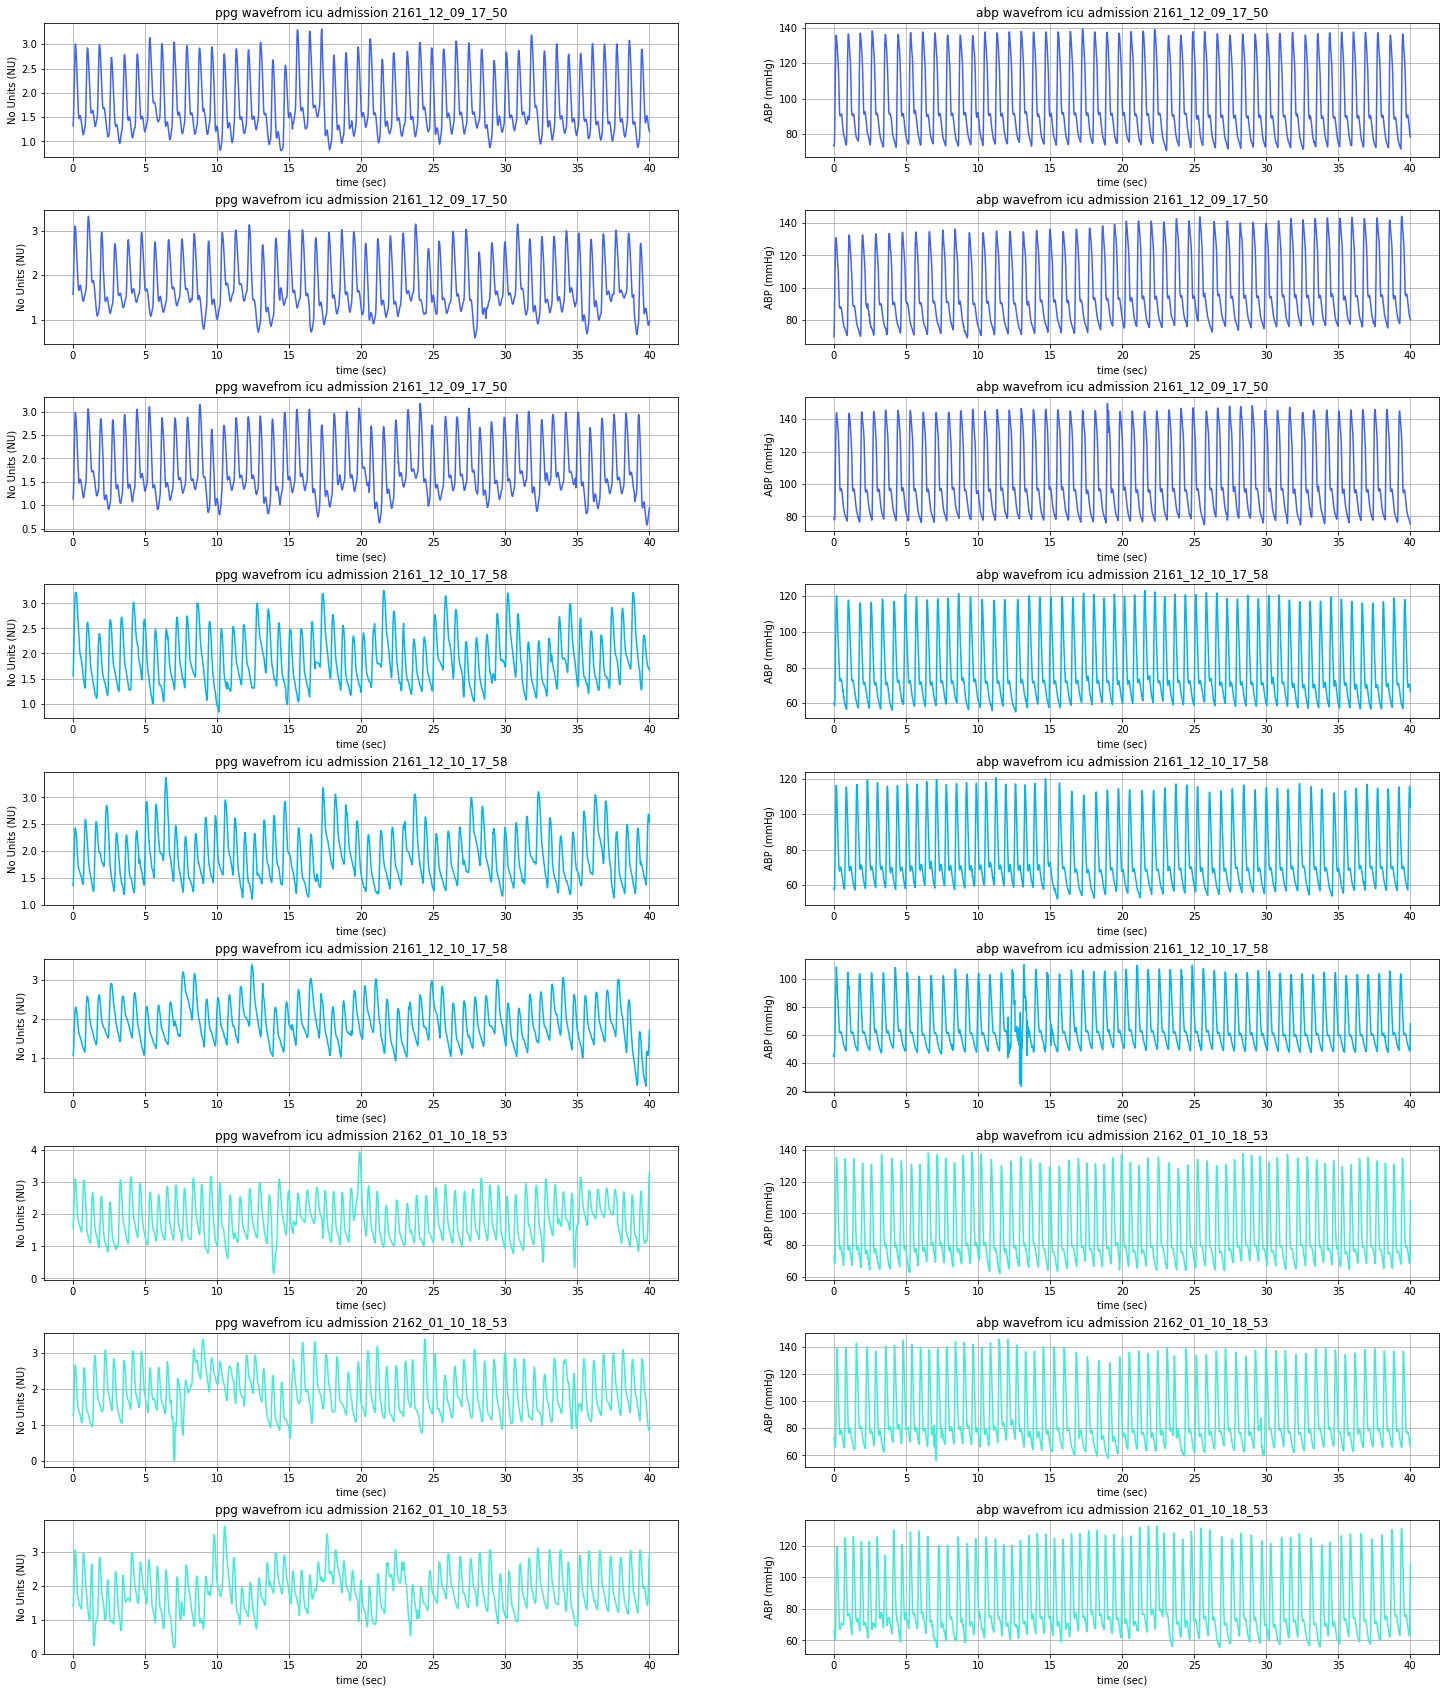

In [10]:
n_plots = 3

fig, axes = plt.subplots(n_plots*n_admiss, 2, figsize=(25,30))
plt.subplots_adjust(hspace=0.4)

color=cm.rainbow(np.linspace(0,1,n_plots*n_admiss))

i,cn = 0, 0
for icu_admission in ppg.datetime.unique():
    for n in range(n_plots):

        axes[i][0].title.set_text('ppg wavefrom icu admission '+ppg.datetime[ppg.datetime == icu_admission].values[i])
        axes[i][0].plot(t,ppg[ppg.datetime == icu_admission].drop(columns=['datetime']).values[i],color=color[cn+1])
        axes[i][0].set_xlabel('time (sec)')
        axes[i][0].set_ylabel('No Units (NU)')
        axes[i][0].grid()

        axes[i][1].title.set_text('abp wavefrom icu admission '+ppg.datetime[ppg.datetime == icu_admission].values[i])
        axes[i][1].plot(t,abp[ppg.datetime == icu_admission].drop(columns=['datetime']).values[i],color=color[cn+1])
        axes[i][1].set_xlabel('time (sec)')
        axes[i][1].set_ylabel('ABP (mmHg)')
        axes[i][1].grid()
        i +=1
    cn +=1
    

plt.show()

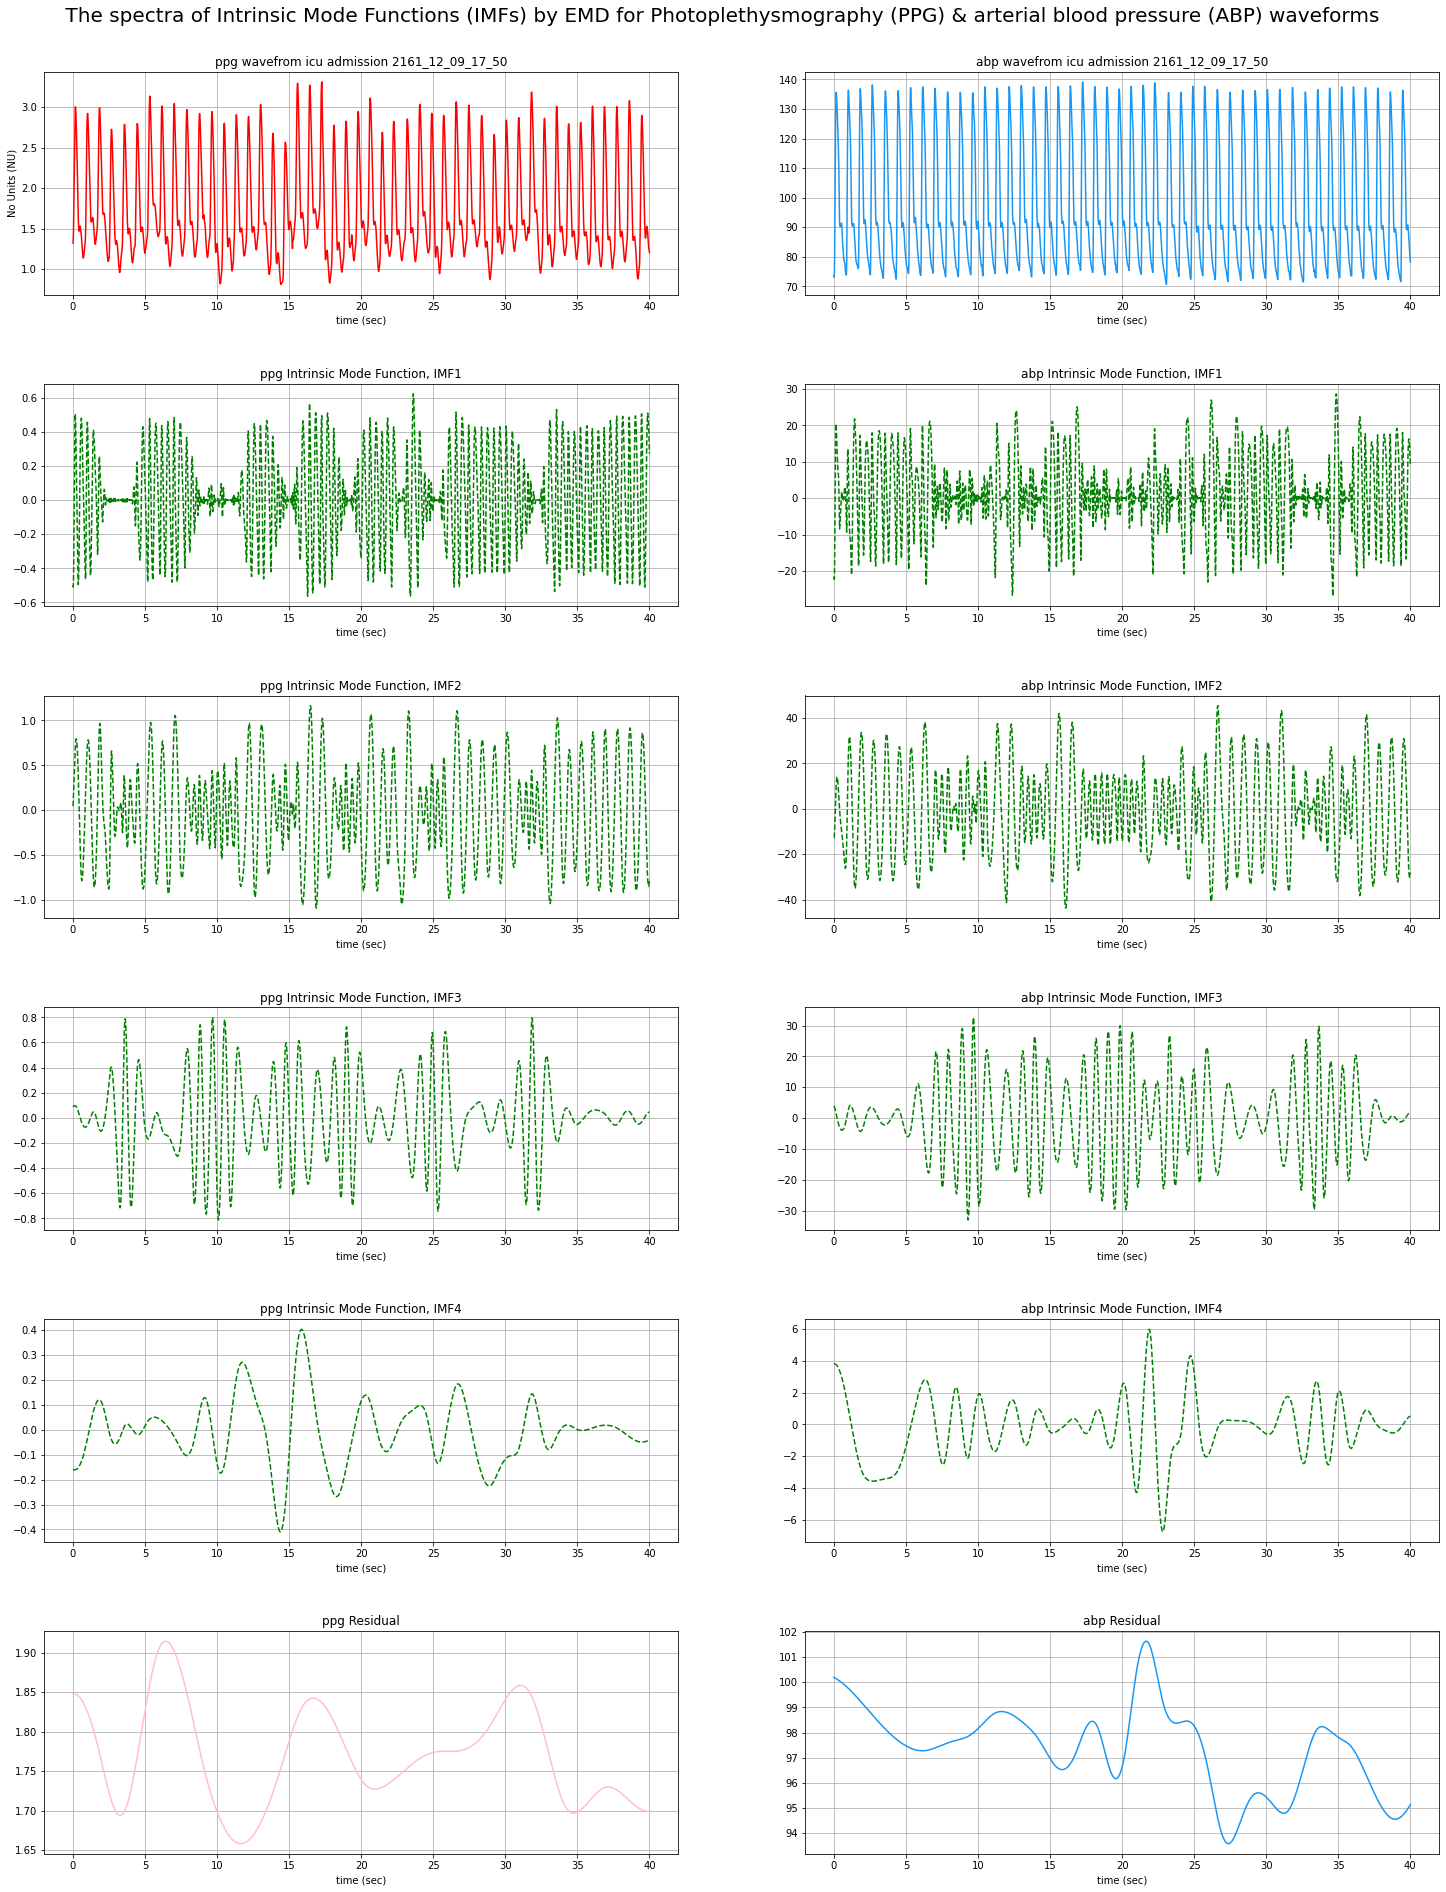

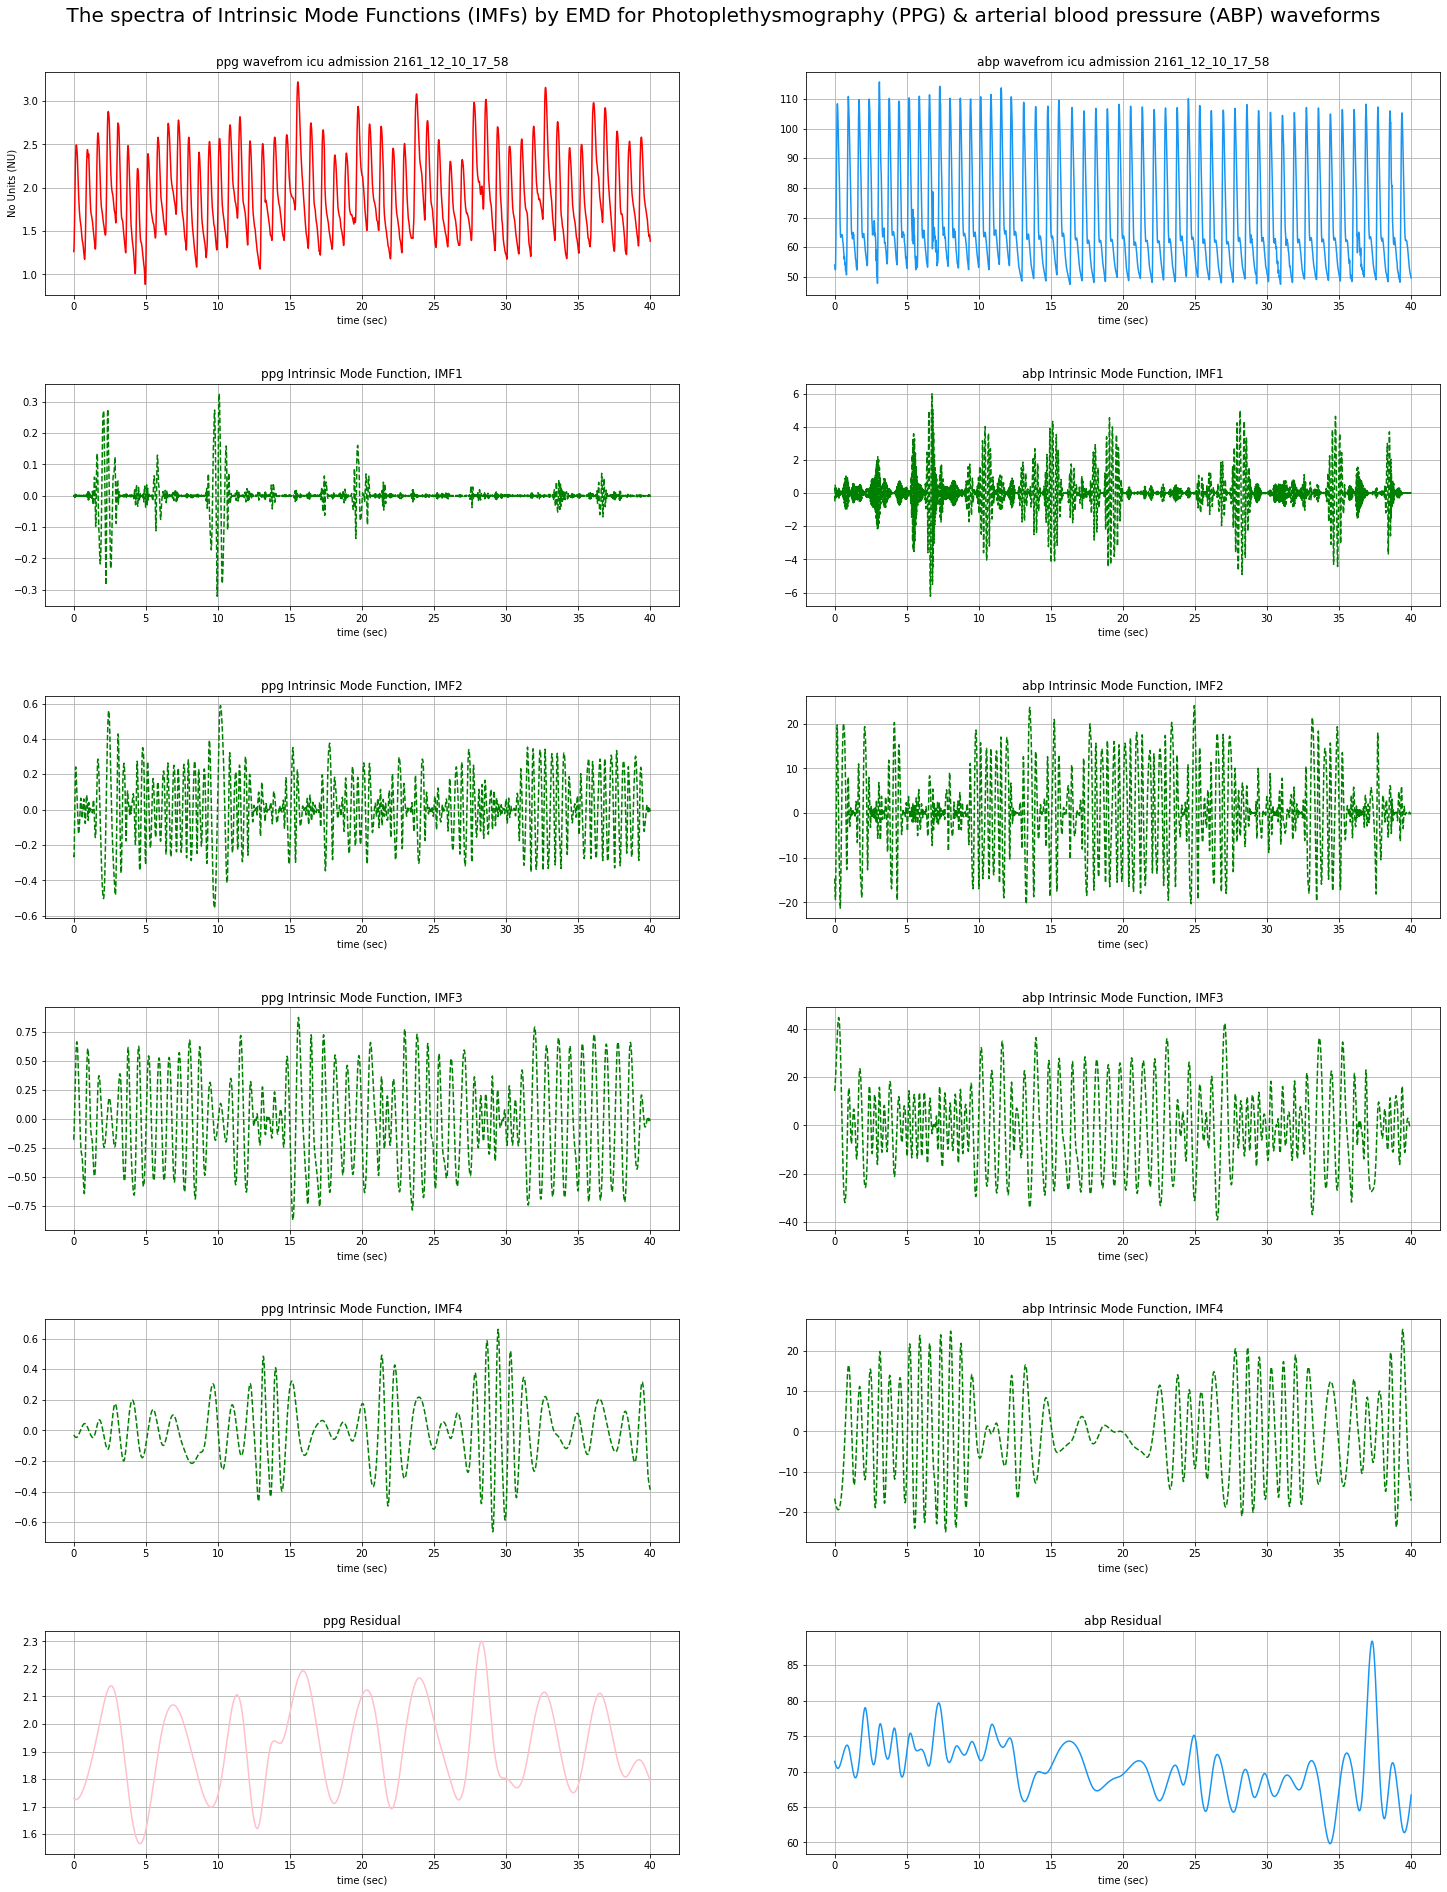

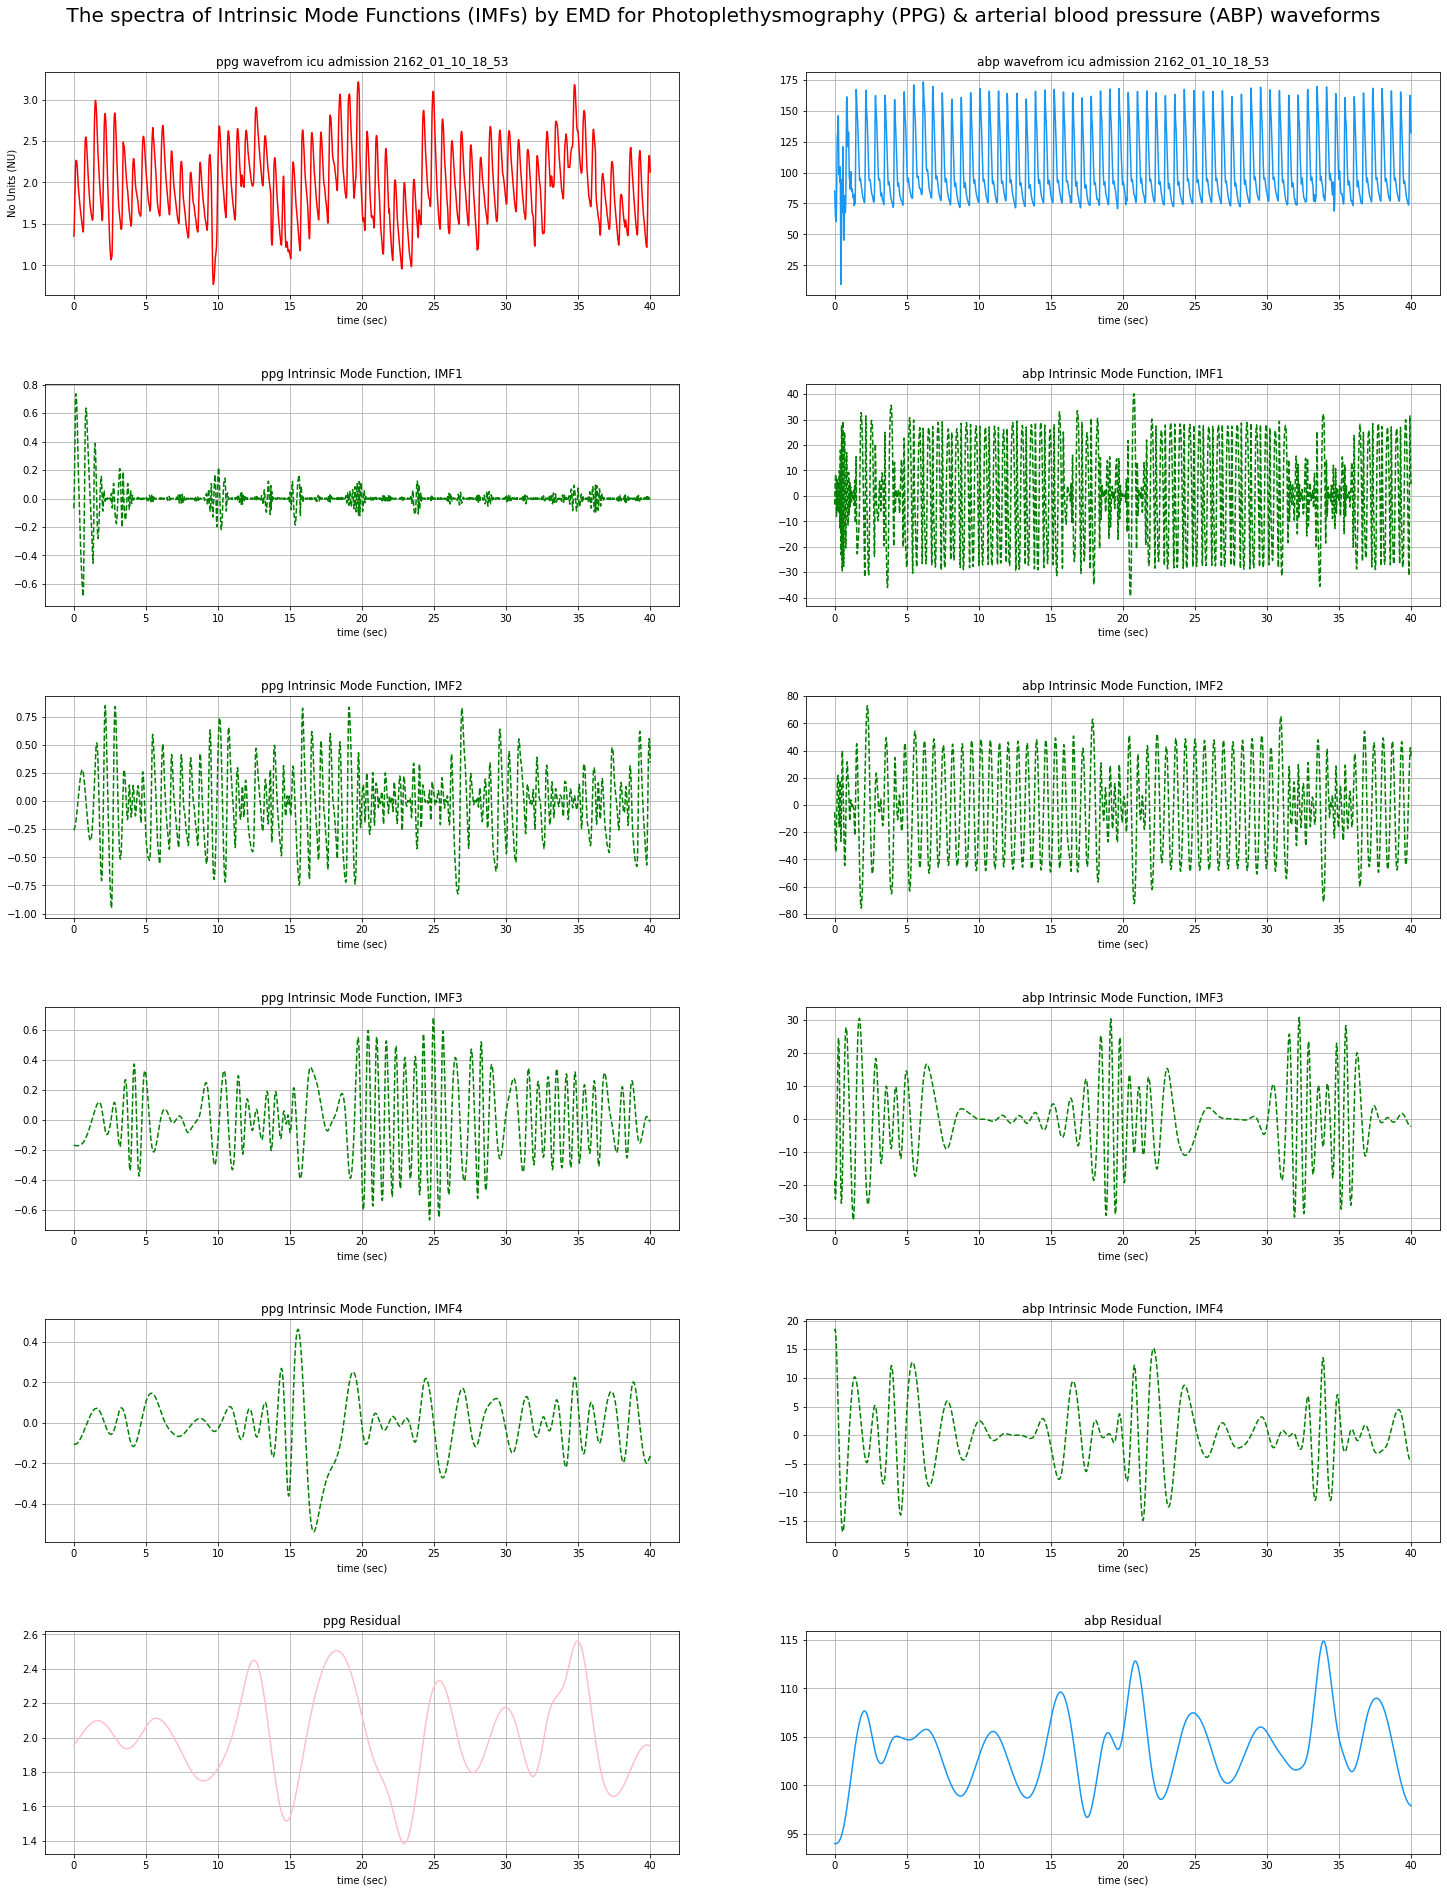

In [11]:
n_plots = 3
n_icu_instances = True
icu_single = False

color=cm.rainbow(np.linspace(0,1,components+2))
emd = EMD(max_imfs=components)
i,cn = 0, 0
for icu_admission in ppg.datetime.unique():
    for n in range(n_plots):
        fig, axes = plt.subplots(components+2, 2, figsize=(25,30))
        fig.suptitle(''' The spectra of Intrinsic Mode Functions (IMFs) by EMD for Photoplethysmography (PPG) & arterial blood pressure (ABP) waveforms''', fontsize=20)
        plt.subplots_adjust(top=0.95,hspace=0.4)
        
        X = ppg[ppg.datetime == icu_admission].drop(columns=['datetime']).values[i]
        
        emd.emd(X, max_imf = components)
        imfs_ppg, res_ppg = emd.get_imfs_and_residue()
        
        Y = abp[abp.datetime == icu_admission].drop(columns=['datetime']).values[i]
        
        emd.emd(Y, max_imf = components)
        imfs_abp, res_abp = emd.get_imfs_and_residue()
        
        axes[0][0].title.set_text('ppg wavefrom icu admission '+ppg.datetime[ppg.datetime == icu_admission].values[i])
        axes[0][0].plot(t, X, 'r')
        axes[0][0].set_xlabel('time (sec)')
        axes[0][0].set_ylabel('No Units (NU)')
        axes[0][0].grid()
        
        for n, imf in enumerate(imfs_ppg):
            axes[n+1][0].title.set_text('ppg Intrinsic Mode Function, IMF'+str(n+1))
            axes[n+1][0].plot(t, imf, '--g')
            axes[n+1][0].set_xlabel('time (sec)')
            axes[n+1][0].grid()
        
        axes[n+2][0].title.set_text('ppg Residual')
        axes[n+2][0].plot(t, res_ppg, 'pink')
        axes[n+2][0].set_xlabel('time (sec)')
        axes[n+2][0].grid()
            
        axes[0][1].title.set_text('abp wavefrom icu admission '+ppg.datetime[ppg.datetime == icu_admission].values[i])
        axes[0][1].plot(t,Y,color=color[cn+1])
        axes[0][1].set_xlabel('time (sec)')
        axes[0][1].grid()
        
        for n, imf in enumerate(imfs_abp):
            axes[n+1][1].title.set_text('abp Intrinsic Mode Function, IMF'+str(n+1))
            axes[n+1][1].plot(t, imf, '--g')
            axes[n+1][1].set_xlabel('time (sec)')
            axes[n+1][1].grid()
        
        axes[n+2][1].title.set_text('abp Residual')
        axes[n+2][1].plot(t,res_abp,color=color[cn+1])
        axes[n+2][1].set_xlabel('time (sec)')
        axes[n+2][1].grid()
        
        
        if n_icu_instances: break
    if icu_single: break

In [ ]:
n_plots = 3
n_icu_instances = True
icu_single = True

imf_freq_limit = [5,30,40,40]
freq_res = [0.1,0.01,0.01,0.01]

In [ ]:
cmap = plt.cm.cividis

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

color=cm.rainbow(np.linspace(0,1,components+2))

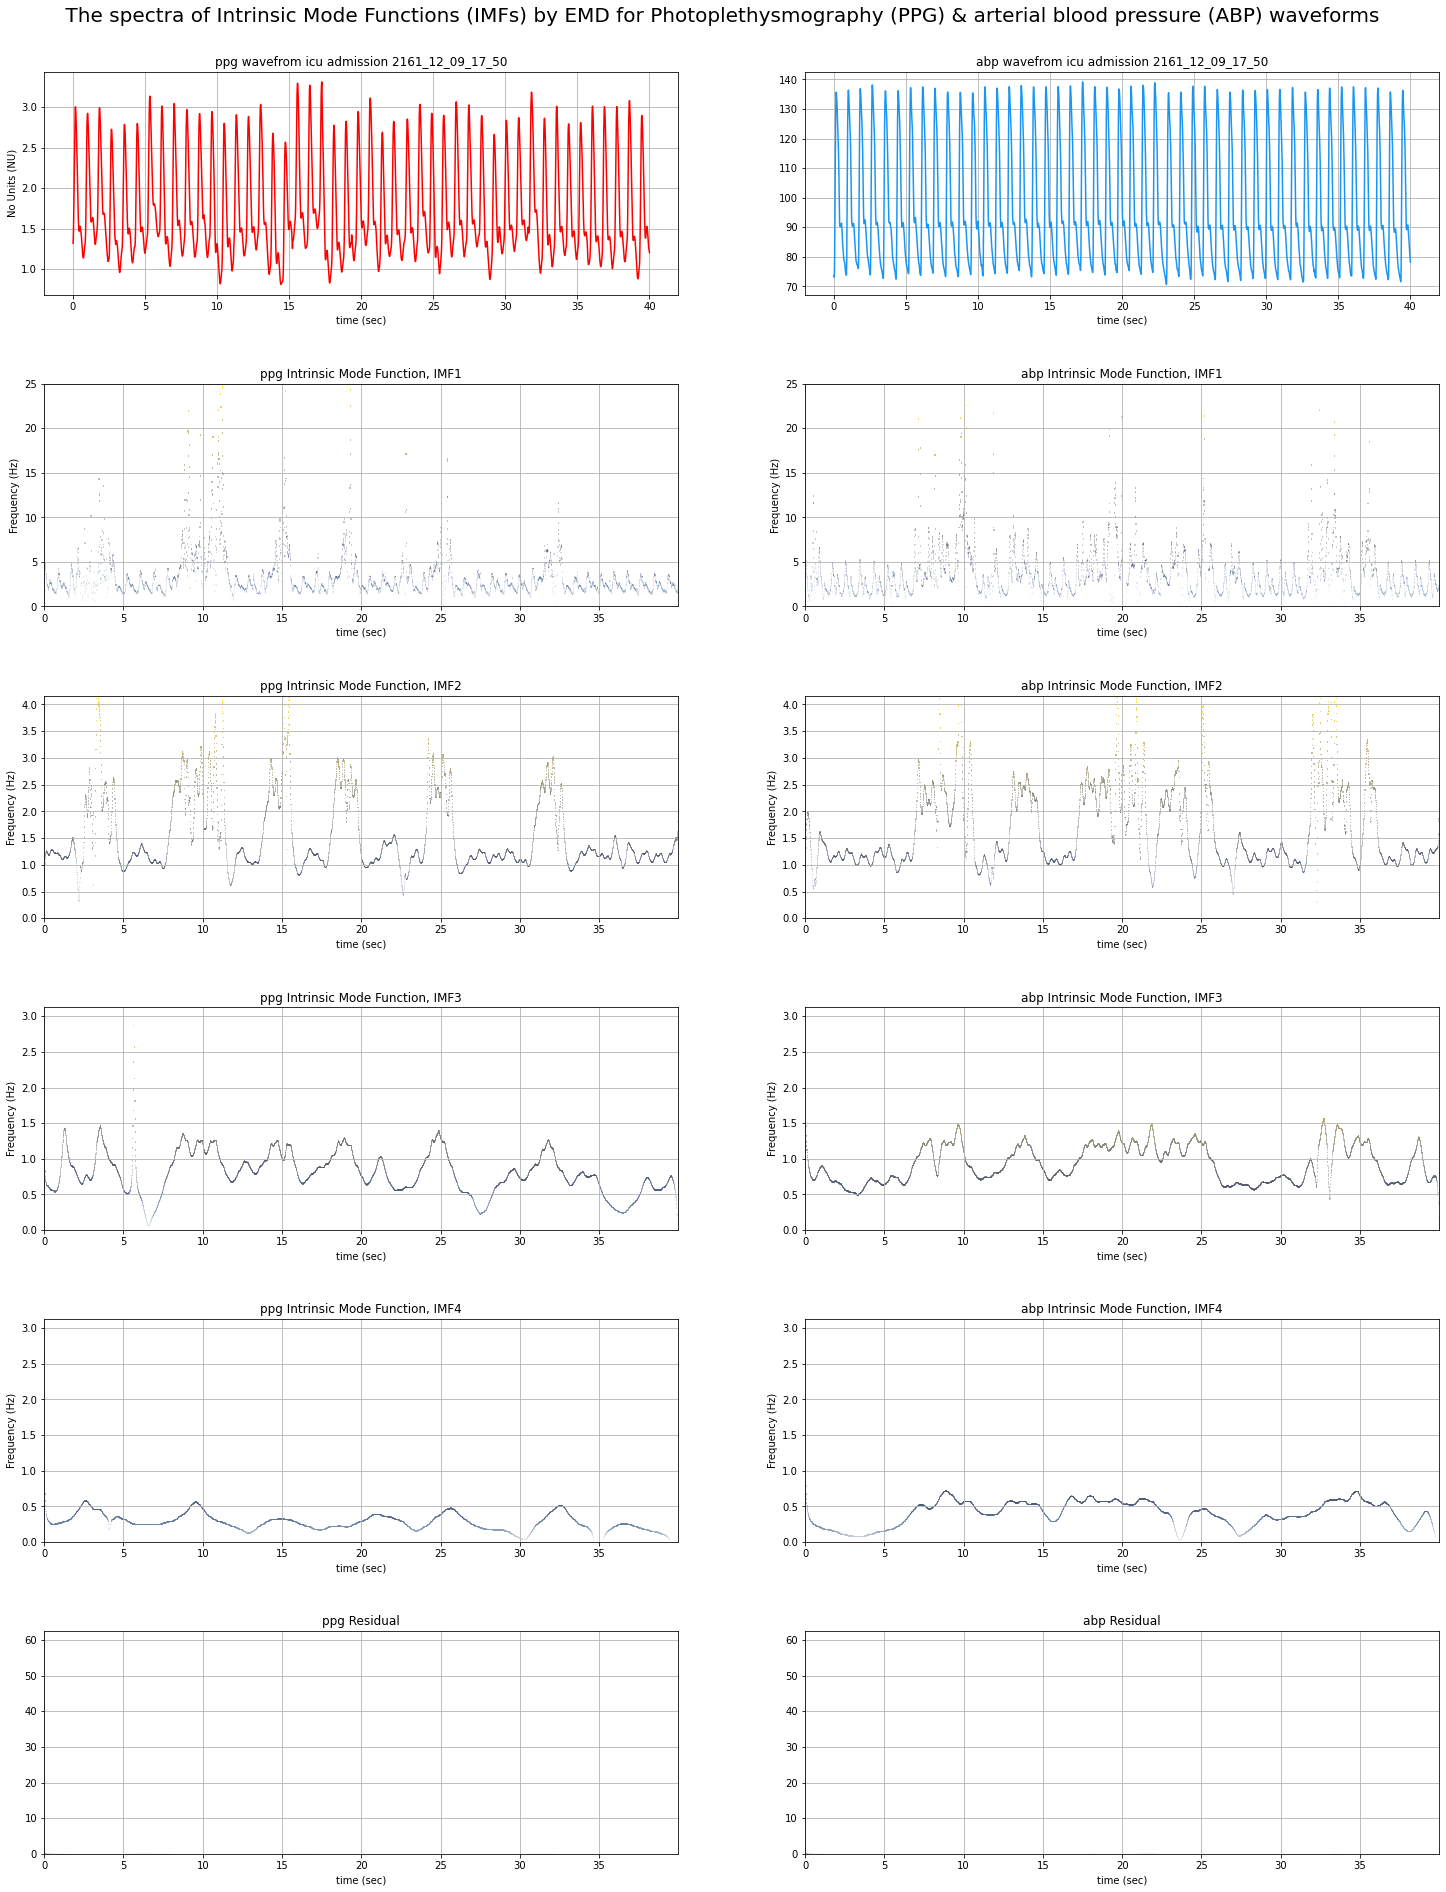

In [12]:
emd = EMD(max_imfs=components)
i,cn = 0, 0
for icu_admission in ppg.datetime.unique():
    for n in range(n_plots):
        fig, axes = plt.subplots(components+2, 2, figsize=(25,30))
        fig.suptitle(''' The spectra of Intrinsic Mode Functions (IMFs) by EMD for Photoplethysmography (PPG) & arterial blood pressure (ABP) waveforms''', fontsize=20)
        plt.subplots_adjust(top=0.95,hspace=0.4)
        
        X = ppg[ppg.datetime == icu_admission].drop(columns=['datetime']).values[i]
        
        emd.emd(X, max_imf = components)
        imfs_ppg, res_ppg = emd.get_imfs_and_residue()
        
        Y = abp[abp.datetime == icu_admission].drop(columns=['datetime']).values[i]
        
        emd.emd(Y, max_imf = components)
        imfs_abp, res_abp = emd.get_imfs_and_residue()
        
        axes[0][0].title.set_text('ppg wavefrom icu admission '+ppg.datetime[ppg.datetime == icu_admission].values[i])
        axes[0][0].plot(t, X, 'r')
        axes[0][0].set_xlabel('time (sec)')
        axes[0][0].set_ylabel('No Units (NU)')
        axes[0][0].grid()
        
        for n, (imf,freq_limit,fres) in enumerate(zip(imfs_ppg,imf_freq_limit,freq_res)):
            
            T,F,P,insf,inse = hht(imf, fs, FResol= fres, freq_min = 0, freq_max = fs/freq_limit)
            
            axes[n+1][0].title.set_text('ppg Intrinsic Mode Function, IMF'+str(n+1))
            axes[n+1][0].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
            axes[n+1][0].set_xlabel('time (sec)')
            axes[n+1][0].set_ylabel('Frequency (Hz)')
            axes[n+1][0].grid()
        
        T,F,P,insf,inse = hht(res_ppg, fs, FResol= fres, freq_min = 0, freq_max = fs/2)
        
        axes[n+2][0].title.set_text('ppg Residual')
        axes[n+2][0].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
        axes[n+2][0].set_xlabel('time (sec)')
        axes[n+1][0].set_ylabel('Frequency (Hz)')
        axes[n+2][0].grid()
            
        axes[0][1].title.set_text('abp wavefrom icu admission '+ppg.datetime[ppg.datetime == icu_admission].values[i])
        axes[0][1].plot(t,Y,color=color[cn+1])
        axes[0][1].set_xlabel('time (sec)')
        axes[0][1].grid()
        
        for n, (imf,freq_limit,fres) in enumerate(zip(imfs_abp,imf_freq_limit,freq_res)):
            T,F,P,insf,inse = hht(imf, fs, FResol= fres, freq_min = 0, freq_max = fs/freq_limit)
            
            axes[n+1][1].title.set_text('abp Intrinsic Mode Function, IMF'+str(n+1))
            axes[n+1][1].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
            axes[n+1][1].set_xlabel('time (sec)')
            axes[n+1][1].set_ylabel('Frequency (Hz)')
            axes[n+1][1].grid()
        
        T,F,P,insf,inse = hht(res_abp, fs, FResol= 0.1, freq_min = 0, freq_max = fs/2)
        
        axes[n+2][1].title.set_text('abp Residual')
        axes[n+2][1].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
        axes[n+2][1].set_xlabel('time (sec)')
        axes[n+1][1].set_ylabel('Frequency (Hz)')
        axes[n+2][1].grid()
        
        
        if n_icu_instances: break
    if icu_single: break

In [30]:
imf.shape

(5000,)

In [32]:
res_abp.shape

(5000,)

In [45]:
T,F,P,insf,inse = hht(res_abp, fs, FResol= 0.1, freq_min = 0, freq_max = fs/100)

In [46]:
P.toarray()

array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.108087, ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

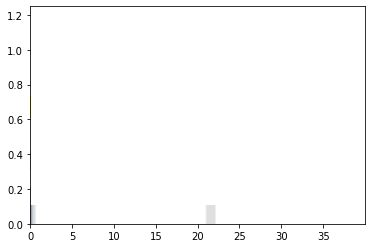

In [47]:
plt.pcolormesh(T,F, P.toarray(),cmap = my_cmap)

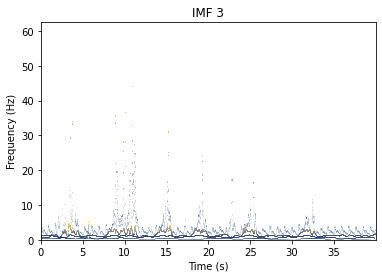

In [20]:
cmap = pl.cm.cividis

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

for n, (imf,freq_limit,freq_res) in enumerate(zip(imfs_ppg,[12,30,40,40],[0.1,0.01,0.01,0.01])):
    #plt.plot(imf)
    T,F,P,insf,inse = hht(imf,fs,FResol= freq_res,
                          freq_min = 0,freq_max =fs/2)
    
    scaler = MinMaxScaler()
    scaler.fit(P.toarray())
    
    #np.min(P[np.nonzero(P)]) P.max() cmap = "RdYlBu",
    cmap = plt.cm.Reds
    img = plt.pcolormesh(T,F, P.toarray(),cmap = my_cmap)#seismic
    
    #plt.colorbar()
    plt.title('IMF '+str(n))
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    #plt.show()
    #break

In [10]:

emd = EMD(max_imfs=4)
for i,sig_ppg in ppg.drop(columns =['datetime']).iterrows():
    emd.emd(sig_ppg.values,max_imf = 4)
    imfs, res = emd.get_imfs_and_residue()
    break

In [34]:
#img.to_rgba(img.get_array().reshape(P.toarray()[:-1, :-1].shape))

In [27]:
#retrieve rgba values of the quadmesh object
rgbas = img.to_rgba(img.get_array().reshape(P.toarray()[:-1, :-1].shape))

In [29]:
rgbas.shape

(312, 4999, 4)

In [30]:
#modify the alpha values
rgbas[:, :, 3] = np.linspace(0, 1, P.toarray()[:-1, :-1].size).reshape(P.toarray()[:-1, :-1].shape)

In [31]:
rgbas.shape

(312, 4999, 4)

In [ ]:
ax2.imshow(rgbas, origin="lower")

In [134]:
# https://stackoverflow.com/questions/34840366/matplotlib-pcolormesh-get-array-returns-flattened-array-how-to-get-2d-dat 
ex_img = img.get_array().reshape(h-1, w-1)# img._meshWidth, img._meshHeight
ex_img.shape

(312, 4999)